In [111]:
import tensorflow as tf

graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int64, shape=[None])

    hidden = tf.layers.dense(
        X, 64, activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )
    
    training = tf.placeholder(dtype=tf.bool)
    hidden = tf.layers.dropout(hidden, rate=0.5, seed=0, training=training)
    
    logits = tf.layers.dense(
        hidden, 4, activation=None,
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )

In [112]:
with graph.as_default():

    # Hidden layer weights
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
    
    # Output layer weights
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')

    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int64)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [113]:
with graph.as_default():
    # L2 term
    l2_term_hidden = tf.nn.l2_loss(W1)
    l2_term_logits = tf.nn.l2_loss(W2)

    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)

    # Loss function
    loss = mean_ce + alpha * (l2_term_hidden + l2_term_logits)

    # Training operation
    train_op = gd.minimize(loss)

In [103]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    df = dict(npz_file.items())
X = df['overfeat']
y = df['labels']

X_tr,X_te,y_tr,y_te = train_test_split(X.astype(np.float32),y,train_size=4000,test_size=1000,random_state=0,stratify = y)
X_tr_tr,X_tr_valid,y_tr_tr,y_tr_valid = train_test_split(X_tr,y_tr,train_size=3200,test_size=800,random_state=0)

In [104]:
# Rescale the train and validation data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr_tr_rescaled = scaler.fit_transform(X_tr_tr)
X_tr_valid_rescaled = scaler.transform(X_tr_valid)

In [105]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) 
    np.random.shuffle(shuffled_idx)

    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [126]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_tr_tr_rescaled, y_tr_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch, 
                lr: 0.001, 
                training: True,
                alpha: 0.1
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_tr_valid_rescaled,
            y: y_tr_valid,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden layer
    weights_hidden = W1.eval()

Epoch 1 - valid: 0.544 train: 0.375 (mean)
Epoch 2 - valid: 0.655 train: 0.518 (mean)
Epoch 3 - valid: 0.710 train: 0.573 (mean)
Epoch 4 - valid: 0.738 train: 0.627 (mean)
Epoch 5 - valid: 0.748 train: 0.654 (mean)
Epoch 6 - valid: 0.752 train: 0.695 (mean)
Epoch 7 - valid: 0.770 train: 0.706 (mean)
Epoch 8 - valid: 0.780 train: 0.715 (mean)
Epoch 9 - valid: 0.783 train: 0.736 (mean)
Epoch 10 - valid: 0.781 train: 0.728 (mean)
Epoch 11 - valid: 0.784 train: 0.756 (mean)
Epoch 12 - valid: 0.801 train: 0.747 (mean)
Epoch 13 - valid: 0.795 train: 0.768 (mean)
Epoch 14 - valid: 0.796 train: 0.770 (mean)
Epoch 15 - valid: 0.801 train: 0.775 (mean)
Epoch 16 - valid: 0.799 train: 0.781 (mean)
Epoch 17 - valid: 0.800 train: 0.775 (mean)
Epoch 18 - valid: 0.805 train: 0.784 (mean)
Epoch 19 - valid: 0.805 train: 0.791 (mean)
Epoch 20 - valid: 0.805 train: 0.794 (mean)
Epoch 21 - valid: 0.804 train: 0.797 (mean)
Epoch 22 - valid: 0.805 train: 0.796 (mean)
Epoch 23 - valid: 0.805 train: 0.807 (mea

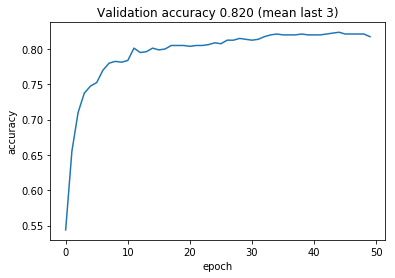

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [140]:
X_tr_rescaled = scaler.transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

# Test Accuracy
test_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_tr_rescaled, y_tr, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch, 
                lr: 0.001, 
                training: True,
                alpha: 0.1
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate test accuracy
        test_acc = sess.run(accuracy, feed_dict={
            X: X_te_rescaled,
            y: y_te,
            training: False # Do not apply dropout
        })
        test_acc_values.append(test_acc)

        # Print progress
        print('Epoch {} - test: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, test_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden layer
    weights_hidden = W1.eval()

Epoch 1 - test: 0.576 train: 0.390 (mean)
Epoch 2 - test: 0.675 train: 0.550 (mean)
Epoch 3 - test: 0.721 train: 0.614 (mean)
Epoch 4 - test: 0.747 train: 0.652 (mean)
Epoch 5 - test: 0.755 train: 0.685 (mean)
Epoch 6 - test: 0.769 train: 0.707 (mean)
Epoch 7 - test: 0.774 train: 0.712 (mean)
Epoch 8 - test: 0.782 train: 0.734 (mean)
Epoch 9 - test: 0.783 train: 0.747 (mean)
Epoch 10 - test: 0.787 train: 0.750 (mean)
Epoch 11 - test: 0.793 train: 0.758 (mean)
Epoch 12 - test: 0.795 train: 0.766 (mean)
Epoch 13 - test: 0.799 train: 0.754 (mean)
Epoch 14 - test: 0.800 train: 0.780 (mean)
Epoch 15 - test: 0.800 train: 0.784 (mean)
Epoch 16 - test: 0.805 train: 0.782 (mean)
Epoch 17 - test: 0.800 train: 0.787 (mean)
Epoch 18 - test: 0.804 train: 0.792 (mean)
Epoch 19 - test: 0.802 train: 0.788 (mean)
Epoch 20 - test: 0.804 train: 0.801 (mean)
Epoch 21 - test: 0.807 train: 0.808 (mean)
Epoch 22 - test: 0.811 train: 0.808 (mean)
Epoch 23 - test: 0.816 train: 0.809 (mean)
Epoch 24 - test: 0.8

In [141]:
print('test accuracy {:.3f} (mean last 3)'.format(np.mean(test_acc_values[-3:])))

test accuracy 0.833 (mean last 3)


# Selected this model to predict cifar4-test results

In [145]:
import numpy as np
with np.load('cifar4-test.npz', allow_pickle=False) as npz_file:
    df = dict(npz_file.items())
df.keys()

dict_keys(['pixels', 'overfeat', 'allow_pickle'])

In [146]:
X_test = df['overfeat']

In [147]:
with tf.Session(graph=graph) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    y_test = sess.run(predictions, feed_dict={
        X: X_test,
        training: False
    })

In [149]:
np.save('test-predictions.npy', y_test)

In [150]:
np.load('test-predictions.npy')

array([2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       1, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 1, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 2,
       1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 2, 0,